In [3]:
!pip install pandas scikit-learn tensorflow transformers matplotlib

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls '/content/drive/My Drive/'


'Colab Notebooks'   glaucoma.csv   Images


In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import tensorflow as tf
from transformers import ViTModel, ViTConfig
import numpy as np

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

def patch_images(images, patch_size):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

def create_vit_model(input_shape=(224, 224, 3), patch_size=16, num_classes=1, d_model=768, num_heads=12, num_layers=12, mlp_dim=3072, dropout=0.1):
    inputs = layers.Input(shape=input_shape)

    patches = layers.Lambda(lambda x: patch_images(x, patch_size))(inputs)
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

    patch_embed = layers.Dense(d_model)(patches)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embed = layers.Embedding(input_dim=num_patches, output_dim=d_model)(positions)
    x = patch_embed + pos_embed

    for _ in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(x1, x1)
        x2 = layers.Add()([attention_output, x])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(mlp_dim, activation="gelu")(x3)
        x3 = layers.Dense(d_model)(x3)
        x3 = layers.Dropout(dropout)(x3)
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)

    return models.Model(inputs=inputs, outputs=outputs)

vit_model = create_vit_model()

vit_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.6258 - loss: 3.3976 - val_accuracy: 0.2596 - val_loss: 0.7074 - learning_rate: 0.0010
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 662ms/step - accuracy: 0.6158 - loss: 0.6310 - val_accuracy: 0.7404 - val_loss: 0.5796 - learning_rate: 0.0010
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 658ms/step - accuracy: 0.7419 - loss: 0.5871 - val_accuracy: 0.7404 - val_loss: 0.5899 - learning_rate: 0.0010
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 706ms/step - accuracy: 0.7419 - loss: 0.5909 - val_accuracy: 0.7404 - val_loss: 0.5934 - learning_rate: 0.0010
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 654ms/step - accuracy: 0.7419 - loss: 0.5953 - val_accuracy: 0.7404 - val_loss: 0.5967 - learning_rate: 0.0010
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 660ms/step - accuracy: 0.7419 - loss: 0.5839 - val_accuracy: 0.7404 - val_loss: 0.5786 - learning_rate: 2.0000e-04
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 651ms/step - accuracy: 0.7419 - loss: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


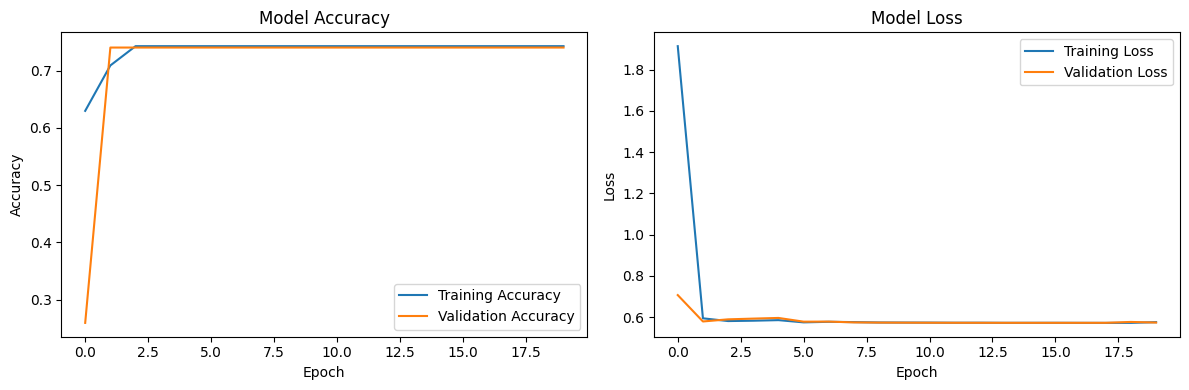

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os
from PIL import Image

def patch_images(images, patch_size):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

def create_vit_model(input_shape=(224, 224, 3), patch_size=16, num_classes=1, d_model=768, num_heads=12, num_layers=12, mlp_dim=3072, dropout=0.1):
    inputs = layers.Input(shape=input_shape)
    patches = layers.Lambda(lambda x: patch_images(x, patch_size))(inputs)
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    patch_embed = layers.Dense(d_model)(patches)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embed = layers.Embedding(input_dim=num_patches, output_dim=d_model)(positions)
    x = patch_embed + pos_embed

    for _ in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(x1, x1)
        x2 = layers.Add()([attention_output, x])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(mlp_dim, activation="gelu")(x3)
        x3 = layers.Dense(d_model)(x3)
        x3 = layers.Dropout(dropout)(x3)
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)
    return models.Model(inputs=inputs, outputs=outputs)

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).resize(target_size)
    img_array = np.array(img) / 255.0  
    return img_array

if __name__ == "__main__":
    dataset_dir = '/content/drive/My Drive/Images/'
    csv_file = '/content/drive/My Drive/glaucoma.csv'

    df = pd.read_csv(csv_file)
    image_paths = [os.path.join(dataset_dir, filename) for filename in df['Filename']]
    labels = df['Glaucoma'].values

    target_size = (224, 224)
    images = np.array([load_and_preprocess_image(path, target_size) for path in image_paths])
    labels = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16).prefetch(tf.data.AUTOTUNE)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16).prefetch(tf.data.AUTOTUNE)

    vit_model = create_vit_model(input_shape=(*target_size, 3))
    vit_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = vit_model.fit(
        train_ds,
        epochs=20,
        validation_data=val_ds,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
        ]
    )

    test_loss, test_accuracy = vit_model.evaluate(test_ds)
    print(f"Test accuracy: {test_accuracy:.4f}")

    y_pred = vit_model.predict(test_ds)
    y_pred_classes = (y_pred > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_classes))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()